# Regresión logística (LR)

In [1]:
# Importar librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report
from time import perf_counter
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importar datos
df = pd.read_csv('Compras.csv')
df.head()

,Identificador,Sexo,Edad,Salario,label
0,15624510,Hombre,19.0,19000,0
1,15810944,Hombre,35.0,20000,0
2,15668575,Mujer,26.0,43000,0
3,15603246,Mujer,27.0,57000,0
4,15804002,Hombre,19.0,76000,0


In [3]:
#Indentificando clase 0 y 1, respectivamente
target_names = ['No compra ', 'Compra']

In [4]:
# Obtener las dimensiones del DataFrame
df.shape

(400, 5)

In [5]:
# Distribución de las clase + y -
df['label'].value_counts()

label
0    257
1    143
Name: count, dtype: int64

In [6]:
#Eliminar datos no necesarios
df.drop(df.columns[0], axis=1, inplace=True)
df.head()

,Sexo,Edad,Salario,label
0,Hombre,19.0,19000,0
1,Hombre,35.0,20000,0
2,Mujer,26.0,43000,0
3,Mujer,27.0,57000,0
4,Hombre,19.0,76000,0


## 1. Preprocesamiento de datos

In [7]:
# Obtener los tipos de datos de las columnas
df.dtypes

Sexo        object
Edad       float64
Salario      int64
label        int64
dtype: object

### 1.1 Codificación de variables categóricas

In [8]:
# Codificación de la variable categórica
label_encoder = LabelEncoder()
df['Sexo_enc'] = label_encoder.fit_transform(df['Sexo'])
# Reordenar las columnas
df = df[['Sexo_enc', 'Edad', 'Salario', 'label']]
df.head()

,Sexo_enc,Edad,Salario,label
0,0,19.0,19000,0
1,0,35.0,20000,0
2,1,26.0,43000,0
3,1,27.0,57000,0
4,0,19.0,76000,0


In [9]:
# Revisar consistencia de datos numéricos
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Sexo_enc,400.0,0.510000,0.500526,0.0,0.0,1.0,1.0,1.0
Edad,399.0,37.681704,10.482406,18.0,30.0,37.0,46.0,60.0
Salario,400.0,69322.500000,34945.048071,-84000.0,43000.0,69500.0,88000.0,150000.0
label,400.0,0.357500,0.479864,0.0,0.0,0.0,1.0,1.0


### 1.2 Datos faltantes

In [10]:
# Identificar datos faltantes
datos_faltantes = df.isnull().sum()
print(datos_faltantes)

Sexo_enc    0
Edad        1
Salario     0
label       0
dtype: int64


In [11]:
# Imputación de datos faltantes con la media
# Calcular la media de la columna 'Edad'
edad_media = df['Edad'].mean()
# Imputar el valor faltante con la media
df['Edad'].fillna(edad_media, inplace=True)

### 1.3 Datos repetidos

In [12]:
# Identificar datos repetidos
duplicados = df.duplicated().any()
print("¿Hay filas duplicadas?:", duplicados)

¿Hay filas duplicadas?: True


In [13]:
# Eliminar filas duplicadas
df.drop_duplicates(inplace=True)

In [14]:
# Obtener las dimensiones del nuevo dataFrame
df.shape

(380, 4)

### 1.4 Valores atípicos

In [15]:
# Calcular el rango intercuartílico (IQR) para cada columna
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Definir límites para identificar valores atípicos
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar valores atípicos
outliers = (df < lower_bound) | (df > upper_bound)

# Resumen de valores atípicos
resumen_outliers = outliers.sum()
print("Resumen de valores atípicos:\n", resumen_outliers)

Resumen de valores atípicos:
 Sexo_enc    0
Edad        0
Salario     1
label       0
dtype: int64


In [16]:
# Imputar valores atípicos
# Calcular la mediana de la columna 'Salario'
salario_mediana = df['Salario'].median()

# Reemplazar los valores atípicos por la mediana
df.loc[(df['Salario'] < lower_bound['Salario']) | (df['Salario'] > upper_bound['Salario']), 'Salario'] = salario_mediana

## 2. EDA

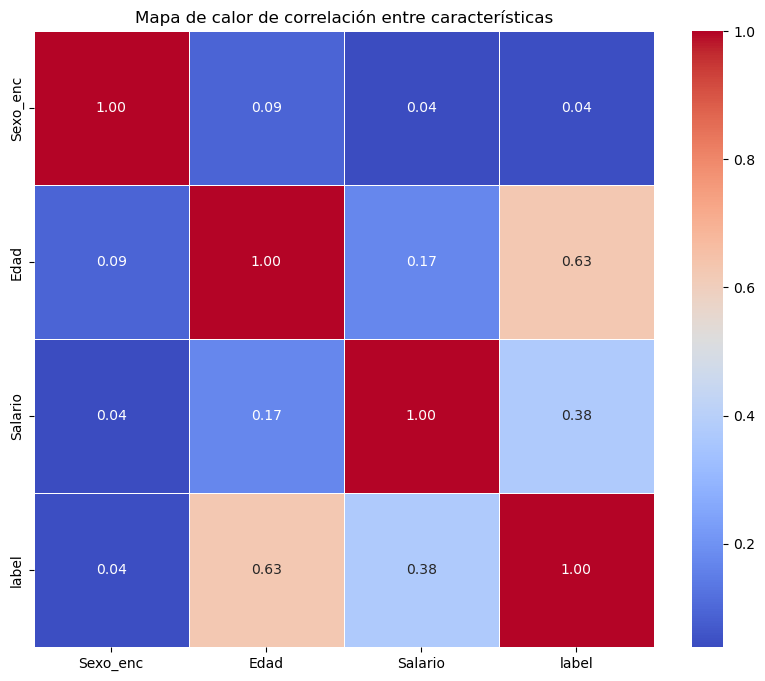

In [17]:
# Calcular la matriz de correlación
#correlation_matrix = df.drop('label', axis=1).corr()
correlation_matrix = df.corr()
# Crear un mapa de calor para visualizar las correlaciones
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Mapa de calor de correlación entre características')
plt.show()

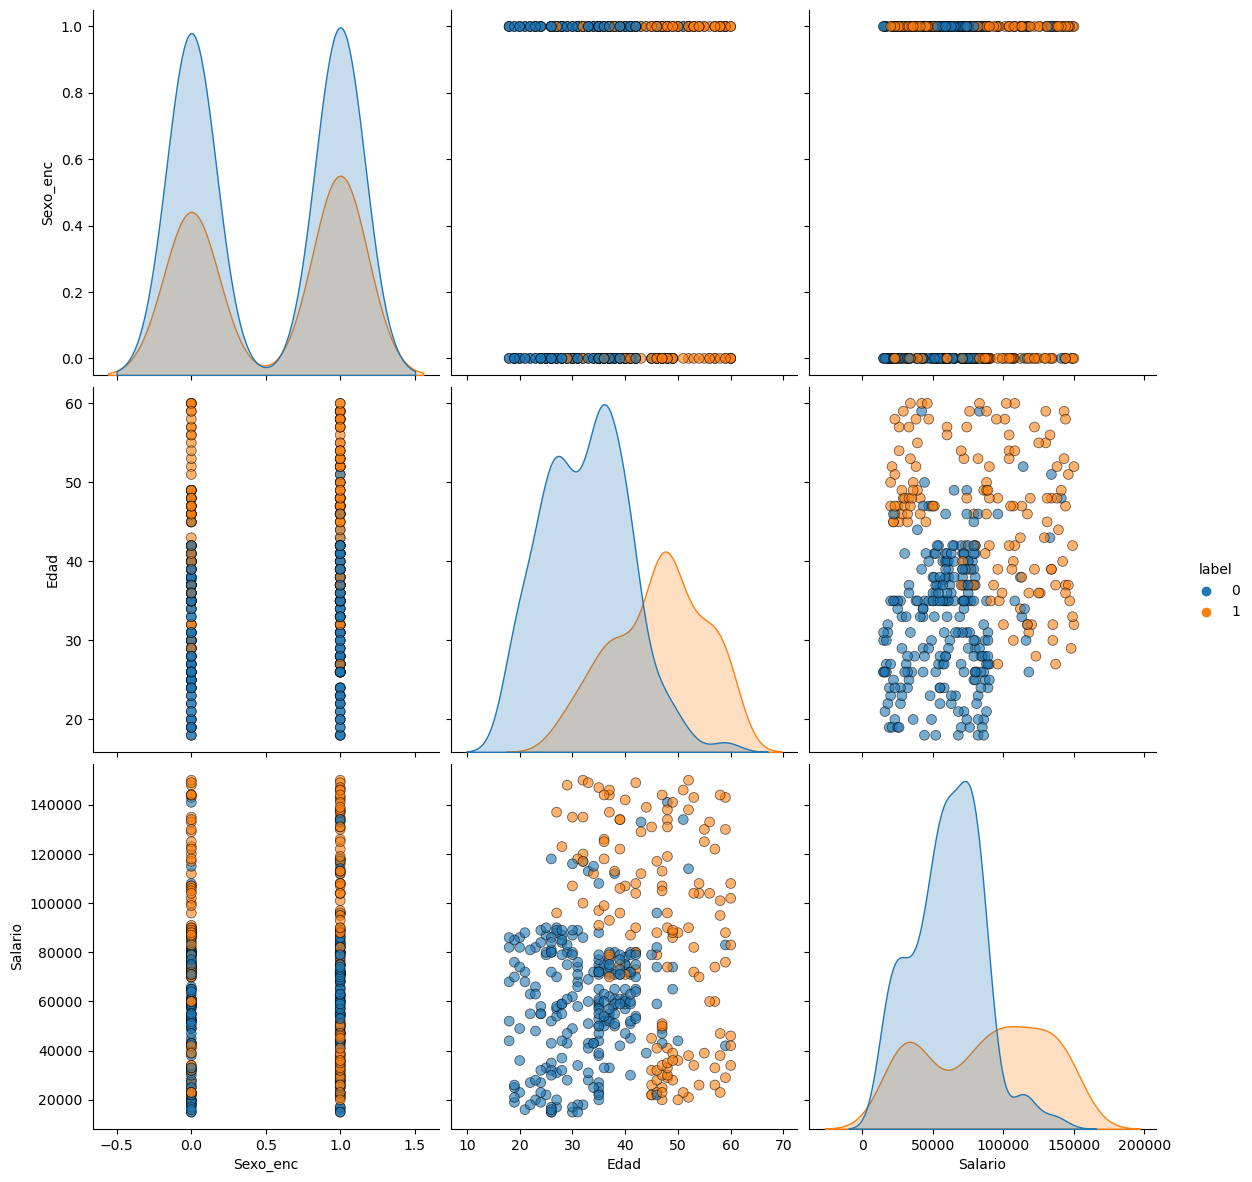

In [18]:
# Creando un scatterplot matrix (matriz de gráficos de dispersión)
sns.pairplot(df, hue='label', diag_kind='kde', plot_kws={'alpha': 0.6, 's': 50, 'edgecolor': 'k'}, height=4)
plt.show()

## 3. Creación de datasets

In [19]:
# Crear matriz de características y de etiquetas
X=df.drop(columns=['label'])
y=df['label']
# Crear datasets de entrenamiento y prueba 
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### 3.1 Escalado de datos

In [20]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [21]:
# Distribución de las clase + y -
y_train.value_counts()

label
0    166
1     88
Name: count, dtype: int64

## 4. Entrenamiento de modelos

### 4.1 Regresión logística

In [22]:
# Definiendo el modelo de regresión logística y el grid de parámetros

parameters = {
    'C': [0.001, 0.01, 0.1,0.5,1, 5, 10, 100, 1000],
    'penalty': ['none', 'l1', 'l2'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

# Iniciando la Grid Search con validación cruzada
model1 = GridSearchCV(
    LogisticRegression(max_iter=1000), # Aumentar el número de iteraciones si es necesario
    parameters,
    cv=5,
    n_jobs=-1,
    verbose=3,
    scoring='recall'
)

# Ajustando el modelo con los datos de entrenamiento escalados
model1.fit(X_train_std, y_train) ; 



Fitting 5 folds for each of 135 candidates, totalling 675 fits


In [23]:
# El mejor modelo encontrado
model1.best_estimator_

LogisticRegression(C=0.1, max_iter=1000, penalty='l1', solver='liblinear')

In [24]:
# Obtener el mejor modelo encontrado por GridSearchCV
best_model = model1.best_estimator_

# Obtener los coeficientes del mejor modelo
coeficientes = best_model.coef_
intercepto = best_model.intercept_

print("Coeficientes del mejor modelo:", coeficientes)
print("Intercepto del mejor modelo:", intercepto)


Coeficientes del mejor modelo: [[0.         1.44634162 0.64387526]]
Intercepto del mejor modelo: [-0.63608707]


              precision    recall  f1-score   support

  No compra        0.84      0.89      0.86        74
      Compra       0.83      0.75      0.79        52

    accuracy                           0.83       126
   macro avg       0.83      0.82      0.83       126
weighted avg       0.83      0.83      0.83       126



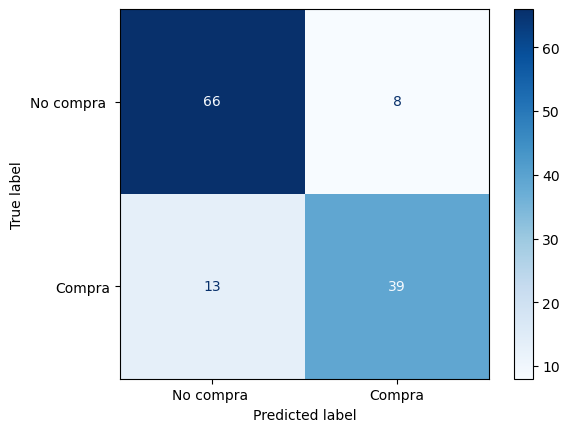

In [25]:
# Realizar predicciones en el conjunto de prueba
y_pred1 = model1.predict(X_test_std)

# Generando el informe de clasificación
print(classification_report(y_test, y_pred1, target_names=target_names))

# Generando y visualizando la matriz de confusión
cm = confusion_matrix(y_test, y_pred1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

disp.plot(cmap=plt.cm.Blues)
plt.show()

### 4.2 Árboles de decisión (DT)

In [26]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
#Run grid search only on training set using cross-validation, n_jobs to -1, it will use all cores
start=perf_counter()
parameters = {'criterion':['gini','entropy'], 'max_depth' : np.arange(1, 20),'max_leaf_nodes': list(range(2, 10)), 
              'min_samples_split': [2, 3, 4, 5, 6],'ccp_alpha': [0.1, .01, .001]}
model3 = GridSearchCV(DecisionTreeClassifier(), parameters, cv=5, n_jobs=-1, verbose=3,scoring='accuracy')
# fit on the trainning dataset
model3.fit(X_train_std, y_train)

Fitting 5 folds for each of 4560 candidates, totalling 22800 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [0.1, 0.01, 0.001],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                         'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9],
                         'min_samples_split': [2, 3, 4, 5, 6]},
             scoring='accuracy', verbose=3)

              precision    recall  f1-score   support

  No compra        1.00      0.81      0.90        74
      Compra       0.79      1.00      0.88        52

    accuracy                           0.89       126
   macro avg       0.89      0.91      0.89       126
weighted avg       0.91      0.89      0.89       126



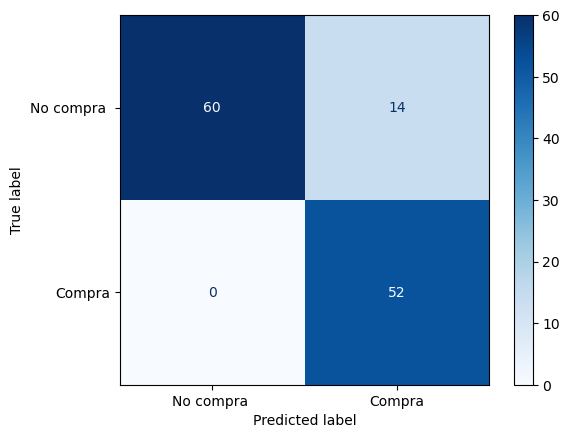

In [27]:
# Realizar predicciones en el conjunto de prueba
y_pred3 = model3.predict(X_test_std)

# Generando el informe de clasificación
print(classification_report(y_test, y_pred3, target_names=target_names))

# Generando y visualizando la matriz de confusión
cm = confusion_matrix(y_test, y_pred3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

disp.plot(cmap=plt.cm.Blues)
plt.show()

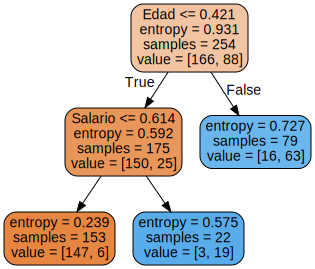

In [28]:
# Visualize how model classified the entire data
# para errores de PATH ejecutar: conda install -c conda-forge python-graphviz
import graphviz
labels=['Sexo_enc', 'Edad', 'Salario']
tree_graph = export_graphviz(model3.best_estimator_, out_file=None, feature_names = labels, rounded=True, filled=True)
graphviz.Source(tree_graph)

### 4.3 LR con dos features

In [29]:
# Eliminar la primera columna del arreglo X_train_std y X_test_std
X_train_std = np.delete(X_train_std, 0, axis=1)
X_test_std = np.delete(X_test_std, 0, axis=1)

In [30]:
# Definiendo el modelo de regresión logística y el grid de parámetros

parameters = {
    'C': [0.001, 0.01, 0.1,0.5,1, 5, 10, 100, 1000],
    'penalty': ['none', 'l1', 'l2'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

# Iniciando la Grid Search con validación cruzada
model1 = GridSearchCV(
    LogisticRegression(max_iter=1000), # Aumentar el número de iteraciones si es necesario
    parameters,
    cv=5,
    n_jobs=-1,
    verbose=3,
    scoring='recall'
)

# Ajustando el modelo con los datos de entrenamiento escalados
model1.fit(X_train_std, y_train)  

Fitting 5 folds for each of 135 candidates, totalling 675 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100, 1000],
                         'penalty': ['none', 'l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='recall', verbose=3)

              precision    recall  f1-score   support

  No compra        0.84      0.89      0.86        74
      Compra       0.83      0.75      0.79        52

    accuracy                           0.83       126
   macro avg       0.83      0.82      0.83       126
weighted avg       0.83      0.83      0.83       126



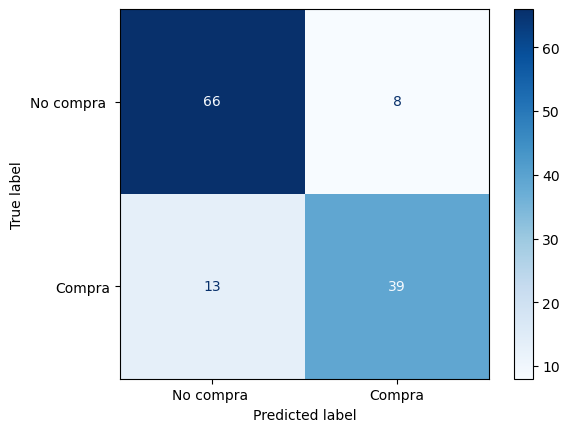

In [31]:
# Realizar predicciones en el conjunto de prueba
y_pred1 = model1.predict(X_test_std)

# Generando el informe de clasificación
print(classification_report(y_test, y_pred1, target_names=target_names))

# Generando y visualizando la matriz de confusión
cm = confusion_matrix(y_test, y_pred1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

disp.plot(cmap=plt.cm.Blues)
plt.show()

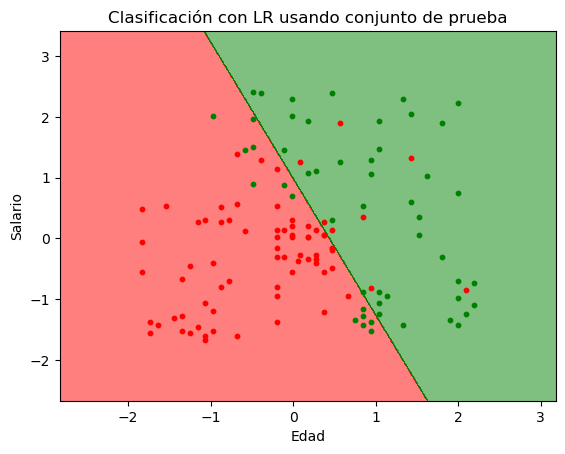

In [32]:
# 9.2 Conjunto de prueba
from matplotlib.colors import ListedColormap as Colors
X_set, y_set = X_test_std, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, model1.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.5, cmap = Colors(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = Colors(('red', 'green'))(i), label = j, s=10)
plt.title('Clasificación con LR usando conjunto de prueba')
plt.xlabel('Edad')
plt.ylabel('Salario')
plt.show()

In [35]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [37]:
# Definir la estrategia de sobremuestreo y submuestreo
over = SMOTE(sampling_strategy={1: 166})  # Sobremuestrear la clase 1 a 166 instancias
under = RandomUnderSampler(sampling_strategy='auto')  # No es necesario submuestrear en este caso

# Crear un pipeline de balanceo
pipeline = Pipeline(steps=[('o', over), ('u', under)])

# Aplicar el balanceo al conjunto de datos
X_resampled, y_resampled = pipeline.fit_resample(X, y)

# Mostrar la distribución de clases antes y después del balanceo
print("Distribución de clases antes del balanceo:", pd.Series(y).value_counts())
print("Distribución de clases después del balanceo:", pd.Series(y_resampled).value_counts())

Distribución de clases antes del balanceo: label
0    240
1    140
Name: count, dtype: int64
Distribución de clases después del balanceo: label
0    166
1    166
Name: count, dtype: int64
